In [8]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
%config InlineBackend.figure_format = 'svg'
import sklearn
from sklearn import datasets
d = sklearn.datasets.fetch_openml("mnist_784", return_X_y=True)

#отображение графиков в ноутбуке
%matplotlib inline 
import random
import timeit
from random import choice
from  scipy import ndimage

In [4]:
def euclidean_distance(X, Y):
    Z = np.sqrt(X**2@np.ones((X.shape[1], 1)) - 2*(X@Y.transpose()) + (Y**2@np.ones((Y.shape[1], 1))).transpose())
    return Z

In [5]:
def cosine_distance(X, Y):
    Z = np.ones((X.shape[0],Y.shape[0])) - X@Y.transpose()*((np.sqrt(X**2@np.ones((X.shape[1], 1))))**(-1))*((np.sqrt(Y**2@np.ones((Y.shape[1], 1))).transpose())**(-1))
    return Z

In [6]:
class KNNClassifier:
    def __init__(self, k, strategy, metric, weights, test_block_size):
        self.k = k
        self.s = strategy
        self.m = metric
        self.w = weights
        self.tbs = test_block_size
    def fit(self, X, y):
        if self.s == 'my_own':
            self.X = X
        elif self.s == 'ball_tree':
            self.temp = NearestNeighbors(n_neighbors=self.k, algorithm=self.s, metric='euclidean')
            self.temp.fit(X)
        elif self.s == 'kd_tree':
            self.temp = NearestNeighbors(n_neighbors=self.k, algorithm=self.s, metric='euclidean')
            self.temp.fit(X)
        elif self.s == 'brute':
            self.temp = NearestNeighbors(n_neighbors=self.k, algorithm=self.s, metric=self.m)
            self.temp.fit(X)
        self.y = y
    def find_kneighbors(self, X, return_distance):
        if self.s == 'my_own':
            Z = np.zeros((X.shape[0], self.k))
            if self.m == 'cosine':
                M = cosine_distance(X, self.X)
            else:
                M = euclidean_distance(X, self.X)
            ind = M.argsort(axis = 1)[:,:self.k]
            if return_distance:
                for i in range(X.shape[0]):
                    for j in range(self.k):
                        Z[i, j] = M[i, ind[i, j]]
                return((Z, ind))
            else:
                return ind
        elif self.s == 'ball_tree':
            return self.temp.kneighbors(X=X, n_neighbors=self.k, return_distance=return_distance)
        elif self.s == 'kd_tree':
            return self.temp.kneighbors(X=X, n_neighbors=self.k, return_distance=return_distance)
        elif self.s == 'brute':
            return self.temp.kneighbors(X=X, n_neighbors=self.k, return_distance=return_distance)
    def predict(self, X):
        Ans = np.zeros((X.shape[0]))
        Cl = np.unique(self.y)[np.newaxis, :]
        Cl = np.append(Cl, np.zeros((1, Cl.shape[1])), axis=0)
        if self.w:
            Y = self.find_kneighbors(X, True)
            for i in range(Y[1].shape[0]):
                Cl[1] = np.zeros(Cl.shape[1])
                for j in range(self.k):
                    for k in range(Cl.shape[1]):
                        if self.y[Y[1][i, j]] == Cl[0, k]:
                            Cl[1, k] += 1/(Y[0][i, j] + 10**(-5))
                Ans[i] = Cl[0, np.argmax(Cl[1])]
        else:
            Y = self.find_kneighbors(X, False)
            for i in range(Y.shape[0]):
                Cl[1] = np.zeros(Cl.shape[1])
                for j in range(self.k):
                    for k in range(Cl.shape[1]):
                        if self.y[Y[i, j]] == Cl[0, k]:
                            Cl[1, k] += 1
                Ans[i] = Cl[0, np.argmax(Cl[1])]
        return Ans

In [7]:
def knn_cross_val_score(X, y, k_list, score, cv=None, **kwargs):
    if cv is None:
        cv = kfold(X.shape[0], 3)
    d = {}
    c = 0
    for i in k_list:
        d[i] = np.zeros(len(cv))
    mx = max(k_list)
    for j in cv:
        C = KNNClassifier(k=mx, **kwargs)
        C.fit(X[j[0]], y[j[0]])
        Cl = np.unique(C.y)[np.newaxis, :]
        Cl = np.append(Cl, np.zeros((1, Cl.shape[1])), axis=0)
        if C.w:
            Yn = C.find_kneighbors(X[j[1]], True)
            for t in range(Yn[1].shape[0]):
                for p in range(mx):
                    Yn[1][t, p] = np.where(Cl[0] == C.y[Yn[1][t, p]])[0]
        else:
            Yn = C.find_kneighbors(X[j[1]], False)
        for i in k_list:
            Ans = np.zeros((X[j[1]].shape[0]))
            if C.w:
                Yt = (Yn[0][:, :i], Yn[1][:, :i])
                for t in range(Yt[1].shape[0]):
                    Cl[1] = np.zeros(Cl.shape[1])
                    for p in range(i):
                        Cl[1][Yt[1][t, p]] += 1/(Yt[0][t, p] + 10**(-5))
                    Ans[t] = Cl[0, np.argmax(Cl[1])]
            else:
                Yt = Yn[:, :i]
                for t in range(Yn.shape[0]):
                    cnts = np.bincount(C.y[Yt[t, :]].astype(int))
                    Ans[t] = np.argmax(cnts)
            d[i][c] = np.sum(Ans == y[j[1]])/len(y[j[1]])
        c += 1
    return d

In [2]:
def kfold(n, n_folds):
    z = n % n_folds
    s = 1
    k = n//n_folds
    k1 = 0
    r = []
    for x in range(n_folds):
        if z <= 0:
            s = 0
        l1 = list(range(k1, k1 + s + k))
        l2 = list(range(0, k1))
        l2 = l2 + (list(range(k1 + s + k, n)))
        r.append((np.array(l2), np.array(l1)))
        z -= 1
        k1 += s + k
    return r

In [7]:
import scipy.spatial.distance as sp
P = np.array(([0, 0, 1], [1, 0, 0], [1, 1, 1], [1, 8, 8]))
K = KNNClassifier(2, 'my_own', 'euclidean', True, 1)
K.fit(P, np.array((1, 0, 1, 2, 3, 1)))
kfold(10, 3)
print(knn_cross_val_score(P, np.array((1, 1, 1, 1)), k_list=[1, 2], score='accuracy', strategy='brute', metric='euclidean', weights=True, test_block_size=1))
#print(K.find_kneighbors(P, True))
#print(K.predict(P))


{1: array([1., 1., 1.]), 2: array([1., 1., 1.])}


In [8]:
import sklearn
from sklearn import datasets
d = sklearn.datasets.fetch_openml("mnist_784", return_X_y=True)

Тест 1

In [84]:
#D_tr = d[0][:600]
#Y_tr = d[1][:600]
#D_vl = d[0][600:700]
#Y_vl = d[0][600:700]
D_tr = d[0][:60000]
Y_tr = d[1][:60000].astype(int)
D_vl = d[0][60000:70000]
Y_vl = d[1][60000:70000].astype(int)
D_tr.shape[1]
Y_tr.shape[0]

60000

In [ ]:
import random
import timeit
t_mo = []
t_b = []
t_bt = []
t_t = []
t_mo_os = []
t_b_os = []
t_bt_os = []
t_t_os = []
for i in [10, 10, 10]:
    n = random.sample(range(D_tr.shape[1]), i)
    D1 = D_tr[:, n]
    D2 = D_vl[:, n]
    Kmo = KNNClassifier(5, 'my_own', 'euclidean', False, 1)
    Kmo.fit(D1, Y_tr)
    a = timeit.default_timer()
    Kmo.find_kneighbors(D2, True)
    t_mo.append(timeit.default_timer()-a)
    Kb = KNNClassifier(5, 'brute', 'euclidean', False, 1)
    Kb.fit(D1, Y_tr)
    a = timeit.default_timer()
    Kb.find_kneighbors(D2, True)
    t_b.append(timeit.default_timer()-a)
    Kt = KNNClassifier(5, 'kd_tree', 'euclidean', False, 1)
    Kt.fit(D1, Y_tr)
    a = timeit.default_timer()
    Kt.find_kneighbors(D2, True)
    t_t.append(timeit.default_timer()-a)
    Kbt = KNNClassifier(5, 'ball_tree', 'euclide', False, 1)
    Kbt.fit(D1, Y_tr)
    a = timeit.default_timer()
    Kbt.find_kneighbors(D2, True)
    t_bt.append(timeit.default_timer()-a)
t_mo_os.append(np.mean(t_mo))
t_b_os.append(np.mean(t_b))
t_t_os.append(np.mean(t_t))
t_bt_os.append(np.mean(t_bt))
for i in [20, 20, 20]:
    n = random.sample(range(D_tr.shape[1]), i)
    D1 = D_tr[:, n]
    D2 = D_vl[:, n]
    Kmo = KNNClassifier(5, 'my_own', 'euclidean', False, 1)
    Kmo.fit(D1, Y_tr)
    a = timeit.default_timer()
    Kmo.find_kneighbors(D2, True)
    t_mo.append(timeit.default_timer()-a)
    Kb = KNNClassifier(5, 'brute', 'euclidean', False, 1)
    Kb.fit(D1, Y_tr)
    a = timeit.default_timer()
    Kb.find_kneighbors(D2, True)
    t_b.append(timeit.default_timer()-a)
    Kt = KNNClassifier(5, 'kd_tree', 'euclidean', False, 1)
    Kt.fit(D1, Y_tr)
    a = timeit.default_timer()
    Kt.find_kneighbors(D2, True)
    t_t.append(timeit.default_timer()-a)
    Kbt = KNNClassifier(5, 'ball_tree', 'euclide', False, 1)
    Kbt.fit(D1, Y_tr)
    a = timeit.default_timer()
    Kbt.find_kneighbors(D2, True)
    t_bt.append(timeit.default_timer()-a)
t_mo_os.append(np.mean(t_mo))
t_b_os.append(np.mean(t_b))
t_t_os.append(np.mean(t_t))
t_bt_os.append(np.mean(t_bt))
for i in [100, 100, 100]:
    n = random.sample(range(D_tr.shape[1]), i)
    D1 = D_tr[:, n]
    D2 = D_vl[:, n]
    Kmo = KNNClassifier(5, 'my_own', 'euclidean', False, 1)
    Kmo.fit(D1, Y_tr)
    a = timeit.default_timer()
    Kmo.find_kneighbors(D2, True)
    t_mo.append(timeit.default_timer()-a)
    Kb = KNNClassifier(5, 'brute', 'euclidean', False, 1)
    Kb.fit(D1, Y_tr)
    a = timeit.default_timer()
    Kb.find_kneighbors(D2, True)
    t_b.append(timeit.default_timer()-a)
    Kt = KNNClassifier(5, 'kd_tree', 'euclidean', False, 1)
    Kt.fit(D1, Y_tr)
    a = timeit.default_timer()
    Kt.find_kneighbors(D2, True)
    t_t.append(timeit.default_timer()-a)
    Kbt = KNNClassifier(5, 'ball_tree', 'euclide', False, 1)
    Kbt.fit(D1, Y_tr)
    a = timeit.default_timer()
    Kbt.find_kneighbors(D2, True)
    t_bt.append(timeit.default_timer()-a)
t_mo_os.append(np.mean(t_mo))
t_b_os.append(np.mean(t_b))
t_t_os.append(np.mean(t_t))
t_bt_os.append(np.mean(t_bt))

In [ ]:
t_mo_os = []
t_b_os = []
t_bt_os = []
t_t_os = []
for i in range(3):
    t_mo_os.append(np.mean(t_mo[i*3:(i+1)*3]))
    t_b_os.append(np.mean(t_b[i*3:(i+1)*3]))
    t_t_os.append(np.mean(t_t[i*3:(i+1)*3]))
    t_bt_os.append(np.mean(t_bt[i*3:(i+1)*3]))
print(np.round(t_mo_os,2))
print(np.round(t_b_os,2))
print(np.round(t_t_os,2))
print(np.round(t_bt_os,2))


[60.72 65.86 73.  ]
[11.26 11.35 14.33]
[  1.68   4.13 145.76]
[  4.8   14.83 182.34]


Опыт 2

In [ ]:
import random
import timeit
t_mo = []
t_mo_c = []
de = []
dc = []
n = random.sample(range(D_tr.shape[1]), i)
kl = list(range(1,11))
a = timeit.default_timer()
de.append(knn_cross_val_score(D_tr, Y_tr, k_list=kl, score='accuracy', strategy='brute', metric='euclidean', weights=False, test_block_size=1))
t_mo.append(timeit.default_timer()-a)
a = timeit.default_timer()
dc.append(knn_cross_val_score(D_tr, Y_tr, k_list=kl, score='accuracy', strategy='brute', metric='cosine', weights=False, test_block_size=1))
t_mo_c.append(timeit.default_timer()-a)

In [ ]:
print(de)
print(dc)
print(t_mo)
print(t_mo_c)

[{1: array([0.96895, 0.96675, 0.9667 ]), 2: array([0.9603 , 0.95995, 0.96125]), 3: array([0.96955, 0.96825, 0.96715]), 4: array([0.96705, 0.9667 , 0.9671 ]), 5: array([0.9681, 0.9673, 0.9672]), 6: array([0.96555, 0.96495, 0.9657 ]), 7: array([0.9652, 0.965 , 0.9656]), 8: array([0.96415, 0.9639 , 0.96525]), 9: array([0.9637 , 0.9632 , 0.96455]), 10: array([0.96245, 0.9622 , 0.9637 ])}]
[{1: array([0.9733 , 0.9708 , 0.97045]), 2: array([0.96895, 0.9664 , 0.96775]), 3: array([0.97365, 0.97155, 0.9709 ]), 4: array([0.9725 , 0.97095, 0.9722 ]), 5: array([0.97275, 0.97015, 0.9716 ]), 6: array([0.97195, 0.9697 , 0.97215]), 7: array([0.97125, 0.96815, 0.97075]), 8: array([0.97125, 0.96835, 0.97155]), 9: array([0.97005, 0.967  , 0.9707 ]), 10: array([0.96935, 0.96615, 0.9707 ])}]
[154.24430275899795]
[148.47147579800003]


In [ ]:
print(de[0])

{1: array([0.96895, 0.96675, 0.9667 ]), 2: array([0.9603 , 0.95995, 0.96125]), 3: array([0.96955, 0.96825, 0.96715]), 4: array([0.96705, 0.9667 , 0.9671 ]), 5: array([0.9681, 0.9673, 0.9672]), 6: array([0.96555, 0.96495, 0.9657 ]), 7: array([0.9652, 0.965 , 0.9656]), 8: array([0.96415, 0.9639 , 0.96525]), 9: array([0.9637 , 0.9632 , 0.96455]), 10: array([0.96245, 0.9622 , 0.9637 ])}


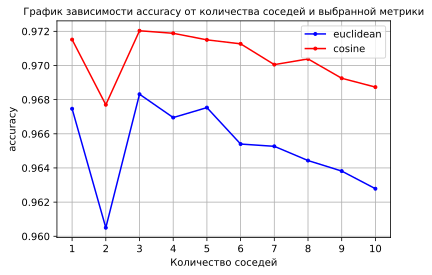

In [ ]:
import random
import timeit
import matplotlib
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'

#отображение графиков в ноутбуке
%matplotlib inline 


t_mo = t_mo2
de = de2

d_e = [de[0][i].mean() for i in de[0].keys()]
d_c = [dc[0][i].mean() for i in dc[0].keys()]

x1 = np.array(np.arange(1, 11), dtype=int)
x2 = np.array(np.arange(1, 11), dtype=int)

plt.plot(x1, d_e, color='blue', label='euclidean',  marker='.')
plt.plot(x2, d_c, color='red', label='cosine',  marker='.')
#for i, val in enumerate(df['counts'].values):
#    plt.text(i, val, float(val), horizontalalignment='center', verticalalignment='bottom', fontdict={'fontweight':500, 'size':12})
plt.xticks(range(1, 11))
plt.xlabel('Количество соседей')
plt.ylabel('accuracy')
plt.title('График зависимости accuracy от количества соседей и выбранной метрики', fontsize=10)
plt.grid(True)
plt.legend()
plt.savefig("exp2.pdf", format="pdf")
plt.show()

In [ ]:
t_mo = []
t_mo_c = []
for i in range(1, 11):
    a = timeit.default_timer()
    Kf = KNNClassifier(i, 'brute', 'euclidean', False, 1)
    Kf.fit(D_tr, Y_tr)
    Y_pr = Kf.predict(D_vl)
    t_mo.append(timeit.default_timer()-a)
    a = timeit.default_timer()
    Kf = KNNClassifier(i, 'brute', 'cosine', False, 1)
    Kf.fit(D_tr, Y_tr)
    Y_pr = Kf.predict(D_vl)
    t_mo_c.append(timeit.default_timer()-a)

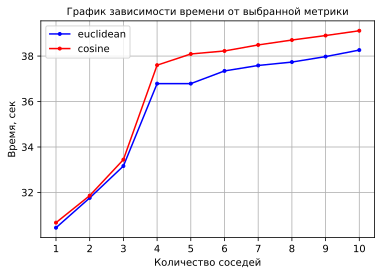

In [ ]:
x1 = np.array(np.arange(1, 11), dtype=int)
x2 = np.array(np.arange(1, 11), dtype=int)
import matplotlib
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'

#отображение графиков в ноутбуке
%matplotlib inline 

plt.plot(x1, t_mo, color='blue', label='euclidean',  marker='.')
plt.plot(x2, t_mo_c, color='red', label='cosine',  marker='.')
plt.xticks(range(1, 11))
#for i, val in enumerate(df['counts'].values):
#    plt.text(i, val, float(val), horizontalalignment='center', verticalalignment='bottom', fontdict={'fontweight':500, 'size':12})

plt.xlabel('Количество соседей')
plt.ylabel('Время, сек')
plt.title('График зависимости времени от выбранной метрики', fontsize=10)
plt.grid(True)
plt.legend()
plt.savefig("exp22.pdf", format="pdf")
plt.show()




Опыт 3


In [115]:

de = []
t_mo = []
a = timeit.default_timer()
de.append(knn_cross_val_score(D_tr, Y_tr, k_list=[2], score='accuracy', strategy='brute', metric='cosine', weights=False, test_block_size=1))
t_mo.append(timeit.default_timer()-a)
a = timeit.default_timer()
de.append(knn_cross_val_score(D_tr, Y_tr, k_list=[2], score='accuracy', strategy='brute', metric='cosine', weights=True, test_block_size=1))
t_mo.append(timeit.default_timer()-a)
a = timeit.default_timer()
de.append(knn_cross_val_score(D_tr, Y_tr, k_list=[3], score='accuracy', strategy='brute', metric='cosine', weights=False, test_block_size=1))
t_mo.append(timeit.default_timer()-a)
a = timeit.default_timer()
de.append(knn_cross_val_score(D_tr, Y_tr, k_list=[3], score='accuracy', strategy='brute', metric='cosine', weights=True, test_block_size=1))
t_mo.append(timeit.default_timer()-a)
a = timeit.default_timer()
de.append(knn_cross_val_score(D_tr, Y_tr, k_list=[4], score='accuracy', strategy='brute', metric='cosine', weights=False, test_block_size=1))
t_mo.append(timeit.default_timer()-a)
a = timeit.default_timer()
de.append(knn_cross_val_score(D_tr, Y_tr, k_list=[4], score='accuracy', strategy='brute', metric='cosine', weights=True, test_block_size=1))
t_mo.append(timeit.default_timer()-a)
a = timeit.default_timer()
de.append(knn_cross_val_score(D_tr, Y_tr, k_list=[5], score='accuracy', strategy='brute', metric='cosine', weights=False, test_block_size=1))
t_mo.append(timeit.default_timer()-a)
a = timeit.default_timer()
de.append(knn_cross_val_score(D_tr, Y_tr, k_list=[5], score='accuracy', strategy='brute', metric='cosine', weights=True, test_block_size=1))
t_mo.append(timeit.default_timer()-a)
a = timeit.default_timer()
de.append(knn_cross_val_score(D_tr, Y_tr, k_list=[6], score='accuracy', strategy='brute', metric='cosine', weights=False, test_block_size=1))
t_mo.append(timeit.default_timer()-a)
a = timeit.default_timer()
de.append(knn_cross_val_score(D_tr, Y_tr, k_list=[6], score='accuracy', strategy='brute', metric='cosine', weights=True, test_block_size=1))
t_mo.append(timeit.default_timer()-a)
a = timeit.default_timer()
de.append(knn_cross_val_score(D_tr, Y_tr, k_list=[7], score='accuracy', strategy='brute', metric='cosine', weights=False, test_block_size=1))
t_mo.append(timeit.default_timer()-a)
a = timeit.default_timer()
de.append(knn_cross_val_score(D_tr, Y_tr, k_list=[7], score='accuracy', strategy='brute', metric='cosine', weights=True, test_block_size=1))
t_mo.append(timeit.default_timer()-a)

[{2: array([0.96895, 0.9664 , 0.96775])}, {2: array([0.9733 , 0.9708 , 0.97045])}, {3: array([0.97365, 0.97155, 0.9709 ])}, {3: array([0.97495, 0.9725 , 0.97175])}, {4: array([0.9725 , 0.97095, 0.9722 ])}, {4: array([0.97545, 0.9732 , 0.97365])}, {5: array([0.97275, 0.97015, 0.9716 ])}, {5: array([0.974  , 0.97095, 0.973  ])}, {6: array([0.97195, 0.9697 , 0.97215])}, {6: array([0.97465, 0.9714 , 0.97305])}, {7: array([0.97125, 0.96815, 0.97075])}, {7: array([0.9726 , 0.9693 , 0.97195])}]


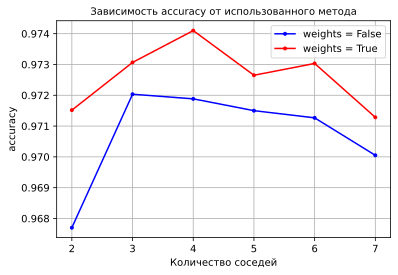

In [116]:
%config InlineBackend.figure_format = 'svg'
x1 = np.array(np.arange(2, 8), dtype=int)
x2 = np.array(np.arange(2, 8), dtype=int)
print(de)

d_e = np.array([de[i][i//2 + 2].mean() for i in range(0, 12)])
d_c = np.array([d_e[i] for i in range(0, 12, 2)])
d_e = np.array([d_e[i] for i in range(1, 12, 2)])

plt.plot(x1, d_c, color='blue', label='weights = False',  marker='.')
plt.plot(x2, d_e, color='red', label='weights = True',  marker='.')
#for i, val in enumerate(df['counts'].values):
#    plt.text(i, val, float(val), horizontalalignment='center', verticalalignment='bottom', fontdict={'fontweight':500, 'size':12})

plt.xlabel('Количество соседей')
plt.ylabel('accuracy')
plt.xticks(range(2, 8))
plt.title('Зависимость accuracy от использованного метода', fontsize=10)
plt.grid(True)
plt.legend()
plt.savefig("exp3.pdf", format="pdf")
plt.show()

[76.43965827200009, 77.1723551340001, 80.75347207800041, 81.77852131100008, 94.67253570499997, 95.94774087099904, 95.04229646099884, 96.28146693599956, 94.49218591499994, 96.53520340799878, 94.59922399500101, 97.07698234199961]


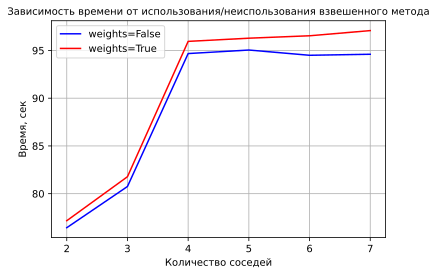

<Figure size 432x288 with 0 Axes>

In [118]:
x1 = np.array(np.arange(2, 8), dtype=int)
x2 = np.array(np.arange(2, 8), dtype=int)
t_t = np.array([t_mo[i] for i in range(0, 12)])
print(t_mo)
t_f = np.array([t_t[i] for i in range(0, 12, 2)])
t_t = np.array([t_t[i] for i in range(1, 12, 2)])
plt.plot(x1, t_f, color='blue', label='weights=False')
plt.plot(x2, t_t, color='red', label='weights=True')
#for i, val in enumerate(df['counts'].values):
#    plt.text(i, val, float(val), horizontalalignment='center', verticalalignment='bottom', fontdict={'fontweight':500, 'size':12})

plt.xlabel('Количество соседей')
plt.ylabel('Время, сек')
plt.title('Зависимость времени от использования/неиспользования взвешенного метода', fontsize=10)
plt.grid(True)
plt.legend()
plt.show()
plt.savefig("exp33.pdf", format="pdf")

Опыт 4

Так, ансамбль из 35 сверточных нейронных сетей в 2012 году сумел получить всего 0.23% ошибок на наборе данных, что является очень хорошим результатом, вполне сравнимым с человеком

In [113]:
ac = knn_cross_val_score(D_tr, Y_tr, k_list=[4], score='accuracy', strategy='brute', metric='cosine', weights=True, test_block_size=1)
Kf = KNNClassifier(4, 'brute', 'cosine', True, 1)
Kf.fit(D_tr, Y_tr)
Y_pr = Kf.predict(D_vl)
accl = np.sum(Y_pr == Y_vl)/len(Y_vl)
M = sklearn.metrics.confusion_matrix(Y_vl, Y_pr)


0.9752
0.9741


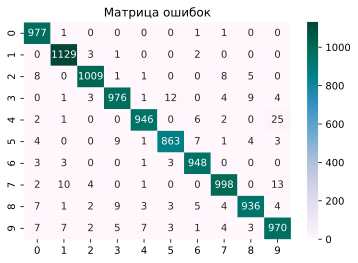

In [114]:
plt.title('Матрица ошибок')
sns.heatmap(M, cmap='PuBuGn', annot=True, fmt='d')
plt.savefig("matr.pdf", format="pdf")
# plt.axis('off')
print(accl)
print(ac[4].mean())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if __name__ == '__main__':


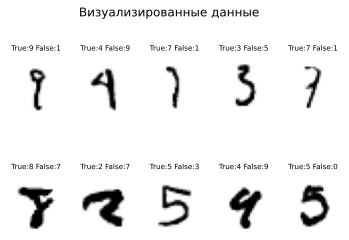

In [23]:
matplotlib.rcParams.update({'font.size': 10})
plt.subplot(251)
k = 1
Ob = []
plt.suptitle('Визуализированные данные')
matplotlib.rcParams.update({'font.size': 6})
for i in range(0, 10000, 10):
    if Y_vl[i] != Y_pr[i]:
        plt.subplot(2, 5, k)
        plt.axis('off')
        plt.imshow(D_vl[i].reshape((28, 28)), cmap='Greys')
        s = 'True:' + str(Y_vl[i]) + ' False:' + str(int(Y_pr[i]))
        plt.title(s)
        if k < 10:
            k += 1
        else:
            break
plt.savefig("Fake.pdf", format="pdf")

Опыт 5 и 6

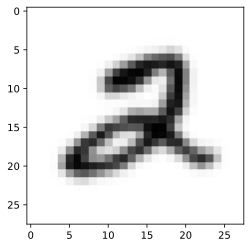

In [120]:

D_tr = d[0][:60000]
Y_tr = d[1][:60000].astype(int)
D_vl = d[0][60000:70000]
Y_vl = d[1][60000:70000].astype(int)
D_tr0 = np.zeros((120000, d[0].shape[1]))
Y_tr0 = np.zeros((120000))
D_ch = np.zeros_like(D_tr)
D_vl0 = np.zeros((20000, d[0].shape[1]))
Y_vl0 = np.zeros((20000))
D_ch_vl = np.zeros_like(D_vl)
matplotlib.rcParams.update({'font.size': 10})
for i in range(D_tr.shape[0]):
    deg = choice([1, -1]) * 5
    D_ch[i] = ndimage.rotate(D_tr[i].reshape((28, 28)), deg, reshape=False, prefilter = False).reshape([-1])
for i in range(D_vl.shape[0]):
    deg = choice([1, -1]) * 5
    D_ch_vl[i] = ndimage.rotate(D_vl[i].reshape((28, 28)), deg, reshape=False, prefilter = False).reshape([-1])
for i in range(D_tr.shape[0]*2):
    if i % 2 == 0:
        D_tr0[i] = D_tr[i//2]
        Y_tr0[i] = Y_tr[i//2]
    else:
        D_tr0[i] = D_ch[i//2]
        Y_tr0[i] = Y_tr[i//2]
for i in range(D_vl.shape[0]*2):
    if i % 2 == 0:
        D_vl0[i] = D_vl[i//2]
        Y_vl0[i] = Y_vl[i//2]
    else:
        D_vl0[i] = D_ch_vl[i//2]
        Y_vl0[i] = Y_vl[i//2]
plt.imshow(D_tr0[11].reshape((28, 28)), cmap='Greys')

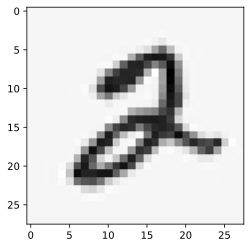

In [49]:
plt.imshow(D_tr0[11].reshape((28, 28)), cmap='Greys')

Случайность в повороте на одинаковый угол посоветовали использовать одногруппники для того, чтобы не случилось переобучения

In [121]:
print(knn_cross_val_score(D_tr0, Y_tr0, k_list=[4], score='accuracy', strategy='brute', metric='cosine', weights=True, test_block_size=1)[4].mean())

0.9763833333333333


In [79]:
Kf = KNNClassifier(4, 'brute', 'cosine', True, 1)
Kf.fit(D_tr, Y_tr)
Y_pr_deg5 = Kf.predict(D_ch_vl)
accl2 = np.sum(Y_pr_deg5 == Y_vl)/len(Y_vl)
M2 = sklearn.metrics.confusion_matrix(Y_vl, Y_pr_deg5)
print(accl2)

0.9717


Поворот на 10

In [122]:
D_tr0 = np.zeros((120000, d[0].shape[1]))
Y_tr0 = np.zeros((120000))
D_ch = np.zeros_like(D_tr)
D_vl0 = np.zeros((20000, d[0].shape[1]))
Y_vl0 = np.zeros((20000))
D_ch_vl = np.zeros_like(D_vl)
D_ch_vl = np.zeros_like(D_vl)
for i in range(D_tr.shape[0]):
    deg = choice([1, -1]) * 10
    D_ch[i] = ndimage.rotate(D_tr[i].reshape((28, 28)), deg, reshape=False, prefilter = False).reshape([-1])
for i in range(D_vl.shape[0]):
    deg = choice([1, -1]) * 10
    D_ch_vl[i] = ndimage.rotate(D_vl[i].reshape((28, 28)), deg, reshape=False, prefilter = False).reshape([-1])
for i in range(D_tr.shape[0]*2):
    if i % 2 == 0:
        D_tr0[i] = D_tr[i//2]
        Y_tr0[i] = Y_tr[i//2]
    else:
        D_tr0[i] = D_ch[i//2]
        Y_tr0[i] = Y_tr[i//2]
for i in range(D_vl.shape[0]*2):
    if i % 2 == 0:
        D_vl0[i] = D_vl[i//2]
        Y_vl0[i] = Y_vl[i//2]
    else:
        D_vl0[i] = D_ch_vl[i//2]
        Y_vl0[i] = Y_vl[i//2]

In [123]:
print(knn_cross_val_score(D_tr0, Y_tr0, k_list=[4], score='accuracy', strategy='brute', metric='cosine', weights=True, test_block_size=1)[4].mean())

0.97575


In [81]:

Kf = KNNClassifier(4, 'brute', 'cosine', True, 1)
Kf.fit(D_tr, Y_tr)
Y_pr_deg10 = Kf.predict(D_ch_vl)
accl2 = np.sum(Y_pr_deg10 == Y_vl)/len(Y_vl)
M2 = sklearn.metrics.confusion_matrix(Y_vl, Y_pr_deg10)
print(accl2)

0.9641


поворот на 15

In [124]:
D_tr0 = np.zeros((120000, d[0].shape[1]))
Y_tr0 = np.zeros((120000))
D_ch = np.zeros_like(D_tr)
D_vl0 = np.zeros((20000, d[0].shape[1]))
Y_vl0 = np.zeros((20000))
D_ch_vl = np.zeros_like(D_vl)
D_ch_vl = np.zeros_like(D_vl)
for i in range(D_tr.shape[0]):
    deg = choice([1, -1]) * 15
    D_ch[i] = ndimage.rotate(D_tr[i].reshape((28, 28)), deg, reshape=False, prefilter = False).reshape([-1])
for i in range(D_vl.shape[0]):
    deg = choice([1, -1]) * 15
    D_ch_vl[i] = ndimage.rotate(D_vl[i].reshape((28, 28)), deg, reshape=False, prefilter = False).reshape([-1])
for i in range(D_tr.shape[0]*2):
    if i % 2 == 0:
        D_tr0[i] = D_tr[i//2]
        Y_tr0[i] = Y_tr[i//2]
    else:
        D_tr0[i] = D_ch[i//2]
        Y_tr0[i] = Y_tr[i//2]
for i in range(D_vl.shape[0]*2):
    if i % 2 == 0:
        D_vl0[i] = D_vl[i//2]
        Y_vl0[i] = Y_vl[i//2]
    else:
        D_vl0[i] = D_ch_vl[i//2]
        Y_vl0[i] = Y_vl[i//2]

In [125]:
print(knn_cross_val_score(D_tr0, Y_tr0, k_list=[4], score='accuracy', strategy='brute', metric='cosine', weights=True, test_block_size=1)[4].mean())

0.9738083333333334


In [83]:

Kf = KNNClassifier(4, 'brute', 'cosine', True, 1)
Kf.fit(D_tr, Y_tr)
Y_pr_deg15 = Kf.predict(D_ch_vl)
accl2 = np.sum(Y_pr_deg15 == Y_vl)/len(Y_vl)
M2 = sklearn.metrics.confusion_matrix(Y_vl, Y_pr_deg15)
print(accl2)

0.9489


In [59]:

Kf = KNNClassifier(4, 'brute', 'cosine', True, 1)
Kf.fit(D_tr0, Y_tr0)
Y_pr = Kf.predict(D_vl)
accl2 = np.sum(Y_pr == Y_vl)/len(Y_vl)
M2 = sklearn.metrics.confusion_matrix(Y_vl, Y_pr)


0.9806


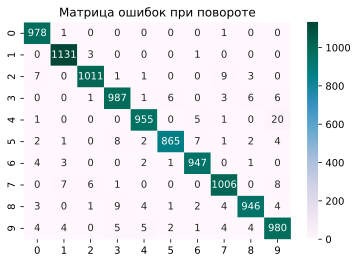

In [60]:
plt.title('Матрица ошибок при повороте')
sns.heatmap(M2, cmap='PuBuGn', annot=True, fmt='d')
plt.savefig("matr5deg.pdf", format="pdf")
# plt.axis('off')
print(accl2)

Величина смещения - 1 пикс

In [126]:
D_tr0 = np.zeros((120000, d[0].shape[1]))
Y_tr0 = np.zeros((120000))
D_ch_px = np.zeros_like(D_tr)
D_vl0 = np.zeros((20000, d[0].shape[1]))
Y_vl0 = np.zeros((20000))
D_ch_vl = np.zeros_like(D_vl)
for i in range(D_tr.shape[0]):
    x = choice([1, -1])
    y = choice([1, -1])
    D_ch_px[i] = ndimage.shift(D_tr[i].reshape((28, 28)), [x, y], cval=0, mode='constant').reshape([-1])
for i in range(D_vl.shape[0]):
    x = choice([1, -1])
    y = choice([1, -1])
    D_ch_vl[i] = ndimage.shift(D_vl[i].reshape((28, 28)), [x, y], cval=0, mode='constant').reshape([-1])
for i in range(D_tr.shape[0]*2):
    if i % 2 == 0:
        D_tr0[i] = D_tr[i//2]
        Y_tr0[i] = Y_tr[i//2]
    else:
        D_tr0[i] = D_ch_px[i//2]
        Y_tr0[i] = Y_tr[i//2]
for i in range(D_vl.shape[0]*2):
    if i % 2 == 0:
        D_vl0[i] = D_vl[i//2]
        Y_vl0[i] = Y_vl[i//2]
    else:
        D_vl0[i] = D_ch_vl[i//2]
        Y_vl0[i] = Y_vl[i//2]

In [127]:
print(knn_cross_val_score(D_tr0, Y_tr0, k_list=[4], score='accuracy', strategy='brute', metric='cosine', weights=True, test_block_size=1)[4].mean())

0.9698166666666667


In [85]:

Kf = KNNClassifier(4, 'brute', 'cosine', True, 1)
Kf.fit(D_tr, Y_tr)
Y_pr_px1 = Kf.predict(D_ch_vl)
accl2 = np.sum(Y_pr_px1 == Y_vl)/len(Y_vl)
M2 = sklearn.metrics.confusion_matrix(Y_vl, Y_pr_px1)
print(accl2)

0.9135


0.9771


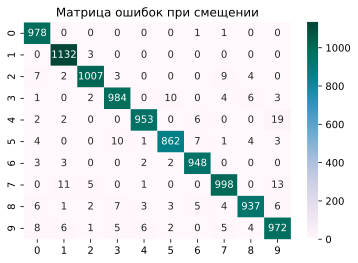

In [71]:

Kf = KNNClassifier(4, 'brute', 'cosine', True, 1)
Kf.fit(D_tr0, Y_tr0)
Y_pr = Kf.predict(D_vl)
accl2 = np.sum(Y_pr == Y_vl)/len(Y_vl)
M2 = sklearn.metrics.confusion_matrix(Y_vl, Y_pr)
plt.title('Матрица ошибок при смещении')
sns.heatmap(M2, cmap='PuBuGn', annot=True, fmt='d')
plt.savefig("matrpx1.pdf", format="pdf")
# plt.axis('off')
print(accl2)

In [ ]:
M2 = sklearn.metrics.confusion_matrix(Y_vl, Y_pr)
sns.heatmap(M3, cmap='PuBuGn', annot=True)
plt.savefig("matr5px1.pdf", format="pdf")
# plt.axis('off')
print(accl2)

In [128]:
D_tr0 = np.zeros((120000, d[0].shape[1]))
Y_tr0 = np.zeros((120000))
D_ch = np.zeros_like(D_tr)
D_vl0 = np.zeros((20000, d[0].shape[1]))
Y_vl0 = np.zeros((20000))
D_ch_vl = np.zeros_like(D_vl)
for i in range(D_tr.shape[0]):
    x = choice([1, -1]) * 2
    y = choice([1, -1]) * 2
    D_ch[i] = ndimage.shift(D_tr[i].reshape((28, 28)), [x, y], cval=0, mode='constant').reshape([-1])
for i in range(D_vl.shape[0]):
    x = choice([1, -1]) * 2
    y = choice([1, -1]) * 2
    D_ch_vl[i] = ndimage.shift(D_vl[i].reshape((28, 28)), [x, y], cval=0, mode='constant').reshape([-1])
for i in range(D_tr.shape[0]*2):
    if i % 2 == 0:
        D_tr0[i] = D_tr[i//2]
        Y_tr0[i] = Y_tr[i//2]
    else:
        D_tr0[i] = D_ch[i//2]
        Y_tr0[i] = Y_tr[i//2]
for i in range(D_vl.shape[0]*2):
    if i % 2 == 0:
        D_vl0[i] = D_vl[i//2]
        Y_vl0[i] = Y_vl[i//2]
    else:
        D_vl0[i] = D_ch_vl[i//2]
        Y_vl0[i] = Y_vl[i//2]

In [129]:
print(knn_cross_val_score(D_tr0, Y_tr0, k_list=[4], score='accuracy', strategy='brute', metric='cosine', weights=True, test_block_size=1)[4].mean())

0.967225


In [87]:

Kf = KNNClassifier(4, 'brute', 'cosine', True, 1)
Kf.fit(D_tr, Y_tr)
Y_pr_px2 = Kf.predict(D_ch_vl)
accl2 = np.sum(Y_pr_px2 == Y_vl)/len(Y_vl)
M2 = sklearn.metrics.confusion_matrix(Y_vl, Y_pr_px2)
print(accl2)

0.5784


In [130]:
D_tr0 = np.zeros((120000, d[0].shape[1]))
Y_tr0 = np.zeros((120000))
D_ch = np.zeros_like(D_tr)
D_vl0 = np.zeros((20000, d[0].shape[1]))
Y_vl0 = np.zeros((20000))
D_ch_vl = np.zeros_like(D_vl)
for i in range(D_tr.shape[0]):
    x = choice([1, -1]) * 3
    y = choice([1, -1]) * 3
    D_ch[i] = ndimage.shift(D_tr[i].reshape((28, 28)), [x, y], cval=0, mode='constant').reshape([-1])
for i in range(D_vl.shape[0]):
    x = choice([1, -1]) * 3
    y = choice([1, -1]) * 3
    D_ch_vl[i] = ndimage.shift(D_vl[i].reshape((28, 28)), [x, y], cval=0, mode='constant').reshape([-1])
for i in range(D_tr.shape[0]*2):
    if i % 2 == 0:
        D_tr0[i] = D_tr[i//2]
        Y_tr0[i] = Y_tr[i//2]
    else:
        D_tr0[i] = D_ch[i//2]
        Y_tr0[i] = Y_tr[i//2]
for i in range(D_vl.shape[0]*2):
    if i % 2 == 0:
        D_vl0[i] = D_vl[i//2]
        Y_vl0[i] = Y_vl[i//2]
    else:
        D_vl0[i] = D_ch_vl[i//2]
        Y_vl0[i] = Y_vl[i//2]

In [131]:
print(knn_cross_val_score(D_tr0, Y_tr0, k_list=[4], score='accuracy', strategy='brute', metric='cosine', weights=True, test_block_size=1)[4].mean())

0.9670666666666667


In [89]:

Kf = KNNClassifier(4, 'brute', 'cosine', True, 1)
Kf.fit(D_tr, Y_tr)
Y_pr_px3 = Kf.predict(D_ch_vl)
accl2 = np.sum(Y_pr_px3 == Y_vl)/len(Y_vl)
M2 = sklearn.metrics.confusion_matrix(Y_vl, Y_pr_px3)
print(accl2)

0.2693


Гаусс

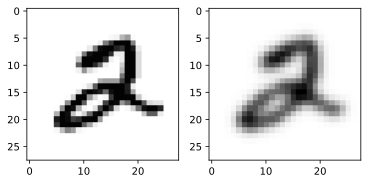

In [132]:
D_tr0 = np.zeros((120000, d[0].shape[1]))
Y_tr0 = np.zeros((120000))
D_ch_g = np.zeros_like(D_tr)
D_vl0 = np.zeros((20000, d[0].shape[1]))
Y_vl0 = np.zeros((20000))
D_ch_vl = np.zeros_like(D_vl)
for i in range(D_tr.shape[0]):
    sig = 1
    D_ch_g[i] = ndimage.gaussian_filter(D_tr[i].reshape((28, 28)), sig, truncate=sig*5).reshape([-1])
for i in range(D_vl.shape[0]):
    sig = 1
    D_ch_vl[i] = ndimage.gaussian_filter(D_vl[i].reshape((28, 28)), sig, truncate=sig*5).reshape([-1])
for i in range(D_tr.shape[0]*2):
    if i % 2 == 0:
        D_tr0[i] = D_tr[i//2]
        Y_tr0[i] = Y_tr[i//2]
    else:
        D_tr0[i] = D_ch_g[i//2]
        Y_tr0[i] = Y_tr[i//2]
for i in range(D_vl.shape[0]*2):
    if i % 2 == 0:
        D_vl0[i] = D_vl[i//2]
        Y_vl0[i] = Y_vl[i//2]
    else:
        D_vl0[i] = D_ch_vl[i//2]
        Y_vl0[i] = Y_vl[i//2]
plt.subplot(121)
plt.imshow(D_tr0[10].reshape((28, 28)), cmap='Greys')
plt.subplot(122)
plt.imshow(D_tr0[11].reshape((28, 28)), cmap='Greys')

In [91]:

Kf = KNNClassifier(4, 'brute', 'cosine', True, 1)
Kf.fit(D_tr, Y_tr)
Y_pr_g1 = Kf.predict(D_ch_vl)
accl2 = np.sum(Y_pr_g1 == Y_vl)/len(Y_vl)
M2 = sklearn.metrics.confusion_matrix(Y_vl, Y_pr_g1)
print(accl2)

0.9613


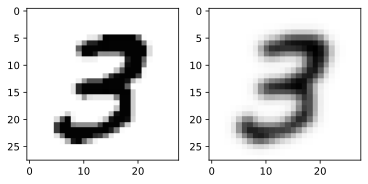

In [69]:
plt.subplot(121)
plt.imshow(D_tr0[14].reshape((28, 28)), cmap='Greys')
plt.subplot(122)
plt.imshow(D_tr0[15].reshape((28, 28)), cmap='Greys')

In [133]:
print(knn_cross_val_score(D_tr0, Y_tr0, k_list=[4], score='accuracy', strategy='brute', metric='cosine', weights=True, test_block_size=1)[4].mean())

0.9779416666666667


In [ ]:
D_tr = d[0][:60000]
Y_tr = d[1][:60000].astype(int)
D_vl = d[0][60000:70000]
Y_vl = d[1][60000:70000].astype(int)
D_tr = np.concatenate((D_ch[0:60000], D_ch_px[0:60000], D_tr[0:60000], D_ch_g[0:60000]), axis=0)
Y_tr = np.concatenate((Y_tr, Y_tr, Y_tr, Y_tr), axis=0)
Kf = KNNClassifier(4, 'brute', 'cosine', True, 1)
Kf.fit(D_tr, Y_tr)
Y_pr = Kf.predict(D_vl)
accl2 = np.sum(Y_pr == Y_vl)/len(Y_vl)
M2 = sklearn.metrics.confusion_matrix(Y_vl, Y_pr)
plt.title('Матрица ошибок с комбинированной выборкой')
sns.heatmap(M2, cmap='PuBuGn', annot=True, fmt='d')
plt.savefig("mainmatr.pdf", format="pdf")
# plt.axis('off')
print(accl2)

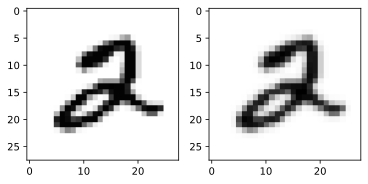

In [134]:
D_tr0 = np.zeros((120000, d[0].shape[1]))
Y_tr0 = np.zeros((120000))
D_ch = np.zeros_like(D_tr)
D_vl0 = np.zeros((20000, d[0].shape[1]))
Y_vl0 = np.zeros((20000))
D_ch_vl = np.zeros_like(D_vl)
for i in range(D_tr.shape[0]):
    sig = 0.5
    D_ch[i] = ndimage.gaussian_filter(D_tr[i].reshape((28, 28)), sig, truncate=sig*5).reshape([-1])
for i in range(D_vl.shape[0]):
    sig = 0.5
    D_ch_vl[i] = ndimage.gaussian_filter(D_vl[i].reshape((28, 28)), sig, truncate=sig*5).reshape([-1])
for i in range(D_tr.shape[0]*2):
    if i % 2 == 0:
        D_tr0[i] = D_tr[i//2]
        Y_tr0[i] = Y_tr[i//2]
    else:
        D_tr0[i] = D_ch[i//2]
        Y_tr0[i] = Y_tr[i//2]
for i in range(D_vl.shape[0]*2):
    if i % 2 == 0:
        D_vl0[i] = D_vl[i//2]
        Y_vl0[i] = Y_vl[i//2]
    else:
        D_vl0[i] = D_ch_vl[i//2]
        Y_vl0[i] = Y_vl[i//2]
plt.subplot(121)
plt.imshow(D_tr0[10].reshape((28, 28)), cmap='Greys')
plt.subplot(122)
plt.imshow(D_tr0[11].reshape((28, 28)), cmap='Greys')

In [135]:
print(knn_cross_val_score(D_tr0, Y_tr0, k_list=[4], score='accuracy', strategy='brute', metric='cosine', weights=True, test_block_size=1)[4].mean())

0.975


In [93]:

Kf = KNNClassifier(4, 'brute', 'cosine', True, 1)
Kf.fit(D_tr, Y_tr)
Y_pr_g05 = Kf.predict(D_ch_vl)
accl2 = np.sum(Y_pr_g05 == Y_vl)/len(Y_vl)
M2 = sklearn.metrics.confusion_matrix(Y_vl, Y_pr_g05)
print(accl2)

0.9738


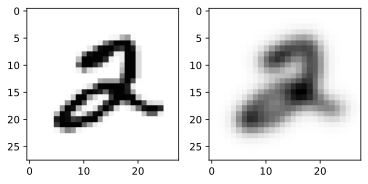

In [136]:
D_tr0 = np.zeros((120000, d[0].shape[1]))
Y_tr0 = np.zeros((120000))
D_ch = np.zeros_like(D_tr)
D_vl0 = np.zeros((20000, d[0].shape[1]))
Y_vl0 = np.zeros((20000))
D_ch_vl = np.zeros_like(D_vl)
for i in range(D_tr.shape[0]):
    sig = 1.5
    D_ch[i] = ndimage.gaussian_filter(D_tr[i].reshape((28, 28)), sig, truncate=sig*5).reshape([-1])
for i in range(D_vl.shape[0]):
    sig = 1.5
    D_ch_vl[i] = ndimage.gaussian_filter(D_vl[i].reshape((28, 28)), sig, truncate=sig*5).reshape([-1])
for i in range(D_tr.shape[0]*2):
    if i % 2 == 0:
        D_tr0[i] = D_tr[i//2]
        Y_tr0[i] = Y_tr[i//2]
    else:
        D_tr0[i] = D_ch[i//2]
        Y_tr0[i] = Y_tr[i//2]
for i in range(D_vl.shape[0]*2):
    if i % 2 == 0:
        D_vl0[i] = D_vl[i//2]
        Y_vl0[i] = Y_vl[i//2]
    else:
        D_vl0[i] = D_ch_vl[i//2]
        Y_vl0[i] = Y_vl[i//2]
plt.subplot(121)
plt.imshow(D_tr0[10].reshape((28, 28)), cmap='Greys')
plt.subplot(122)
plt.imshow(D_tr0[11].reshape((28, 28)), cmap='Greys')

In [137]:
print(knn_cross_val_score(D_tr0, Y_tr0, k_list=[4], score='accuracy', strategy='brute', metric='cosine', weights=True, test_block_size=1)[4].mean())

0.9753666666666666


In [95]:

Kf = KNNClassifier(4, 'brute', 'cosine', True, 1)
Kf.fit(D_tr, Y_tr)
Y_pr_g15 = Kf.predict(D_ch_vl)
accl2 = np.sum(Y_pr_g15 == Y_vl)/len(Y_vl)
M2 = sklearn.metrics.confusion_matrix(Y_vl, Y_pr_g15)
print(accl2)

0.9191


0.9814


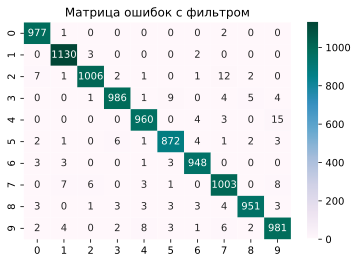

In [64]:

Kf = KNNClassifier(4, 'brute', 'cosine', True, 1)
Kf.fit(D_tr0, Y_tr0)
Y_pr = Kf.predict(D_vl)
accl2 = np.sum(Y_pr == Y_vl)/len(Y_vl)
M2 = sklearn.metrics.confusion_matrix(Y_vl, Y_pr)
plt.title('Матрица ошибок с фильтром')
sns.heatmap(M2, cmap='PuBuGn', annot=True, fmt='d')
plt.savefig("matrg1.pdf", format="pdf")
# plt.axis('off')
print(accl2)

In [ ]:
plt.savefig("matr5px1.pdf", format="pdf")
sns.heatmap(M3, cmap='PuBuGn', annot=True)
# plt.axis('off')
print(accl2)

In [96]:
Kf = KNNClassifier(4, 'brute', 'cosine', True, 1)
Kf.fit(D_tr, Y_tr)
Y_pr_0 = Kf.predict(D_vl)

In [33]:
print(D_tr.shape[0])
print(D_tr.shape[1])

60000
784


In [97]:
Y_deg = [Y_pr_0, Y_pr, Y_pr_deg10, Y_pr_deg15]
Y_px = [Y_pr_0, Y_pr_px1, Y_pr_px2, Y_pr_px3]
Y_g = [Y_pr_0, Y_pr_g05, Y_pr_g1, Y_pr_g15]

In [98]:
acc = np.zeros((4, 4, 4))
for i in range(4):
    for j in range(4):
        for k in range(4):
            Y_pr_comb = np.zeros((Y_pr_0.shape[0]))
            for n in range(Y_pr_0.shape[0]):
                cnts = np.bincount([Y_deg[i][n], Y_px[j][n], Y_g[k][n]])
                Y_pr_comb[n] = np.argmax(cnts)
            acc[i, j, k] = np.sum(Y_pr_comb == Y_vl)/len(Y_vl)
acc1 = np.zeros((4, 4))
for i in range(4):
    for j in range(4):
        Y_pr_comb = np.zeros((Y_pr_0.shape[0]))
        for n in range(Y_pr_0.shape[0]):
            cnts = np.bincount([Y_deg[i][n], Y_g[k][n], Y_pr_0[n]])
            Y_pr_comb[n] = np.argmax(cnts)
        acc1[i, j] = np.sum(Y_pr_comb == Y_vl)/len(Y_vl)
acc3 = np.zeros(4)

In [104]:
print(np.where(acc == 0.9787))
print(np.where(acc1 > 0.9752))
print(np.where(acc3 > 0.9752))

(array([1]), array([1]), array([0]))
(array([1, 1, 1, 1]), array([0, 1, 2, 3]))
(array([], dtype=int64),)


In [102]:
print(np.argmax(acc, axis=0))
print(np.argmax(acc1, axis=0))
print(np.argmax(acc3, axis=0))
print(acc1)
print(acc)

[[0 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]]
[1 1 1 1]
0
[[0.9752 0.9752 0.9752 0.9752]
 [0.9779 0.9779 0.9779 0.9779]
 [0.9685 0.9685 0.9685 0.9685]
 [0.9662 0.9662 0.9662 0.9662]]
[[[0.9752 0.9752 0.9752 0.9752]
  [0.9752 0.9748 0.9698 0.9637]
  [0.9752 0.974  0.9671 0.9485]
  [0.9752 0.9741 0.9653 0.9431]]

 [[0.9752 0.9759 0.9777 0.9779]
  [0.9787 0.9782 0.973  0.9669]
  [0.977  0.9762 0.9698 0.9517]
  [0.9765 0.9755 0.9676 0.9461]]

 [[0.9752 0.9743 0.9718 0.9685]
  [0.9739 0.9737 0.9674 0.9595]
  [0.9682 0.9672 0.9619 0.9441]
  [0.9673 0.9664 0.958  0.9372]]

 [[0.9752 0.9745 0.9715 0.9662]
  [0.9705 0.9706 0.9664 0.9555]
  [0.9625 0.9623 0.9565 0.9372]
  [0.9576 0.9571 0.9498 0.9283]]]


0.9787


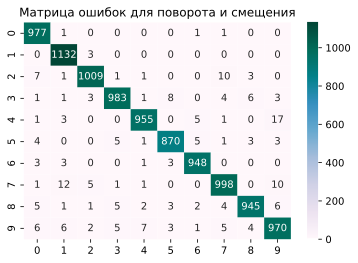

In [105]:
matplotlib.rcParams.update({'font.size': 10})
acc2 = np.zeros((4, 4, 4))
Y_pr_comb = np.zeros((Y_pr_0.shape[0]))
for n in range(Y_pr_0.shape[0]):
    cnts = np.bincount([Y_deg[1][n], Y_px[1][n], Y_g[0][n]])
    Y_pr_comb[n] = np.argmax(cnts)
acc2 = np.sum(Y_pr_comb == Y_vl)/len(Y_vl)
plt.title('Матрица ошибок для поворота и смещения')
M2 = sklearn.metrics.confusion_matrix(Y_vl, Y_pr_comb)
sns.heatmap(M2, cmap='PuBuGn', annot=True, fmt='d')
plt.savefig("matr5px1.pdf", format="pdf")
# plt.axis('off')
print(acc2)

0.9754


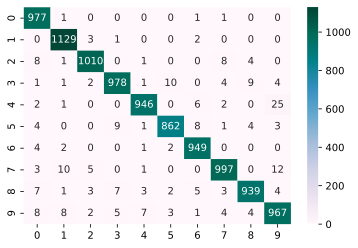

In [120]:
acc2 = np.zeros((4, 4, 4))
Y_pr_comb = np.zeros((Y_pr_0.shape[0]))
for n in range(Y_pr_0.shape[0]):
    cnts = np.bincount([Y_deg[2][n], Y_px[0][n], Y_g[1][n]])
    Y_pr_comb[n] = np.argmax(cnts)
acc2 = np.sum(Y_pr_comb == Y_vl)/len(Y_vl)
M2 = sklearn.metrics.confusion_matrix(Y_vl, Y_pr_comb)
sns.heatmap(M2, cmap='PuBuGn', annot=True, fmt='d')
plt.savefig("matr5g1.pdf", format="pdf")
# plt.axis('off')
print(acc2)

0.9753


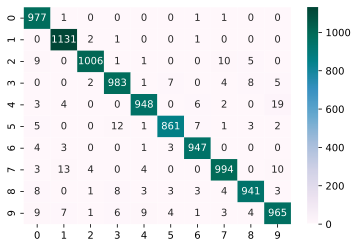

In [121]:
acc2 = np.zeros((4, 4, 4))
Y_pr_comb = np.zeros((Y_pr_0.shape[0]))
for n in range(Y_pr_0.shape[0]):
    cnts = np.bincount([Y_deg[1][n], Y_px[1][n], Y_g[0][n]])
    Y_pr_comb[n] = np.argmax(cnts)
acc2 = np.sum(Y_pr_comb == Y_vl)/len(Y_vl)
M2 = sklearn.metrics.confusion_matrix(Y_vl, Y_pr_comb)
sns.heatmap(M2, cmap='PuBuGn', annot=True, fmt='d')
plt.savefig("matr10g05.pdf", format="pdf")
# plt.axis('off')
print(acc2)

In [ ]:
Чуть лучших результатов чем на оригинальной выборке показало сочетание 102 и 201, 110 -- Гауссиан с 0.5 и поворот на 10 и Гауссиан с 1 и поворот на 5, сдвиг на 1 пиксель и поворот на 5

Опыт 5 на всех данных с нужными параметрами - ноль смещения гауссиан 1.5 и поворот на 15 градусов

1. https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea
2. https://stackoverflow.com/questions/25216382/gaussian-filter-in-scipy